In [1]:
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import SeqIO

# Paired-end Read Merging and Trimming of FKHM Oligos

### Trimming

In [2]:
def extract_structured_oligo_sequences(input_fastq):
    """
    Processes the first 10 examples in the FASTQ file and prints trimmed sequences that match the expected oligo structure:
    Non-binding sequence (NBS) - TGTTTAC - TCGA - NNNNNNN - NBS.
    
    Requirements for a valid trimmed sequence:
    - It starts with the TGTTTAC FKHM (7 bp)
    - We check the first TCGA spacer after the upstream sequence and FKHM
    - Sequence must be 18 bp total (TGTTTAC + TCGA + 7bp variable region)
    - The 5bp flanking NBS motifs (AAATT upstream, AATTC downstream) must be present
    - No ambiguous 'N' bases allowed in the variable region
    """

    sequence_counter = 0
    print(f"Processing {input_fastq}")

    with open(input_fastq, "rt") as infile:
        for record in SeqIO.parse(infile, "fastq"):
            sequence = str(record.seq)
            sequence_counter += 1
            print(f"Full sequence #{sequence_counter}: {sequence}")

            # Find the TCGA motif after the expected upstream region (~27nt upstream + 7nt TGTTTAC)
            # Skip any TCGA occurrences too early in the sequence
            tcga_index = sequence.find("TCGA")
            while tcga_index != -1 and tcga_index < 34:
                tcga_index = sequence.find("TCGA", tcga_index + 1)

            if tcga_index != -1:
                # Look for the upstream 5bp non-binding motif ("AAATT") ending just before the TGTTTAC motif
                start_index = sequence.rfind("AAATT", 0, tcga_index - 7)
                if start_index != -1:
                    start_index += 5  # Move to the position immediately after "AAATT"

                # Look for the downstream 5bp non-binding motif ("AATTC") that follows the variable region
                end_index = sequence.find("AATTC", tcga_index + 11)

                # Proceed only if both flanking motifs are found and in the correct order
                if start_index != -1 and end_index != -1 and start_index < end_index:
                    trimmed_seq = sequence[start_index:end_index]

                    # Ensure the trimmed sequence is exactly 18bp and starts with TGTTTAC
                    # Also check that the variable region (last 7bp) contains no 'N'
                    if len(trimmed_seq) == 18 and 'N' not in trimmed_seq and trimmed_seq.startswith("TGTTTAC"):
                        print(f"Trimmed sequence #{sequence_counter}: {trimmed_seq}")
                    else:
                        print(f'Incorrect sequence length/does not start with FKHM')
                else:
                    print(f'Incorrect non-binding sequence')
            else:
                print(f'No TCGA spacer found')

        print('')

# Run on example FASTQ files (first 5 reads each, because full file would be too large)
extract_structured_oligo_sequences("figure1_files/foxp3_rep1_first5.fastq")
extract_structured_oligo_sequences("figure1_files/foxp3_rep2_first5.fastq")

Processing figure1_files/foxp3_rep1_first5.fastq
Full sequence #1: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGAACTGCCGAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #1: TGTTTACTCGAACTGCCG
Full sequence #2: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGAGAATACCAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #2: TGTTTACTCGAGAATACC
Full sequence #3: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGATACATTCAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #3: TGTTTACTCGATACATTC
Full sequence #4: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGACAACCGCAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #4: TGTTTACTCGACAACCGC
Full sequence #5: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGAGGGTCACAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #5: TGTTTACTCGAGGGTCAC

Processing figure1_files/foxp3_rep2_first5.fastq
Full sequence #1: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGACACGGCAAATTCATCAGCTGGGAGAACAATCATC
Trimmed sequence #1: TGTTTACTCGACACGGCA
Full sequence #2: GTAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTTTACTCGAGAA

### Pre-Processing the Trimmed Reads

In [3]:
# Load counts summary table of trimmed sequences
summary_df = pd.read_csv("figure1_files/fkhm+ran_summary.csv")

In [4]:
summary_df.head()

,sequence,Foxp1_Counts,Foxp3_Counts,Input_Counts
0,AAAAAAA,439,120,642
1,AAAAAAC,2735,4810,1153
2,AAAAAAG,978,232,867
3,AAAAAAT,1306,652,826
4,AAAAACA,2415,6561,1099


In [5]:
# Normalize raw counts to Reads Per Million (RPM)
total_counts_foxp3 = summary_df['Foxp3_Counts'].sum()
total_counts_foxp1 = summary_df['Foxp1_Counts'].sum()
total_counts_input = summary_df['Input_Counts'].sum()

summary_df['Foxp3_Counts_RPM'] = summary_df['Foxp3_Counts'] / total_counts_foxp3 * 1e6
summary_df['Foxp1_Counts_RPM'] = summary_df['Foxp1_Counts'] / total_counts_foxp1 * 1e6
summary_df['Input_Counts_RPM'] = summary_df['Input_Counts'] / total_counts_input * 1e6

# Calculate Enrichment Ratios
summary_df['Foxp3/Input_RPM'] = summary_df['Foxp3_Counts_RPM'] / summary_df['Input_Counts_RPM']
summary_df['Foxp1/Input_RPM'] = summary_df['Foxp1_Counts_RPM'] / summary_df['Input_Counts_RPM']

In [6]:
summary_df.head()

,sequence,Foxp1_Counts,Foxp3_Counts,Input_Counts,Foxp3_Counts_RPM,Foxp1_Counts_RPM,Input_Counts_RPM,Foxp3/Input_RPM,Foxp1/Input_RPM
0,AAAAAAA,439,120,642,5.768708,17.268129,26.585281,0.216989,0.649537
1,AAAAAAC,2735,4810,1153,231.229034,107.581625,47.745839,4.842915,2.253215
2,AAAAAAG,978,232,867,11.152835,38.469773,35.902552,0.310642,1.071505
3,AAAAAAT,1306,652,826,31.343312,51.371701,34.204738,0.916344,1.501888
4,AAAAACA,2415,6561,1099,315.404094,94.994378,45.509694,6.930481,2.087344


### Plots related to PD-seq sequence counts and enrichment

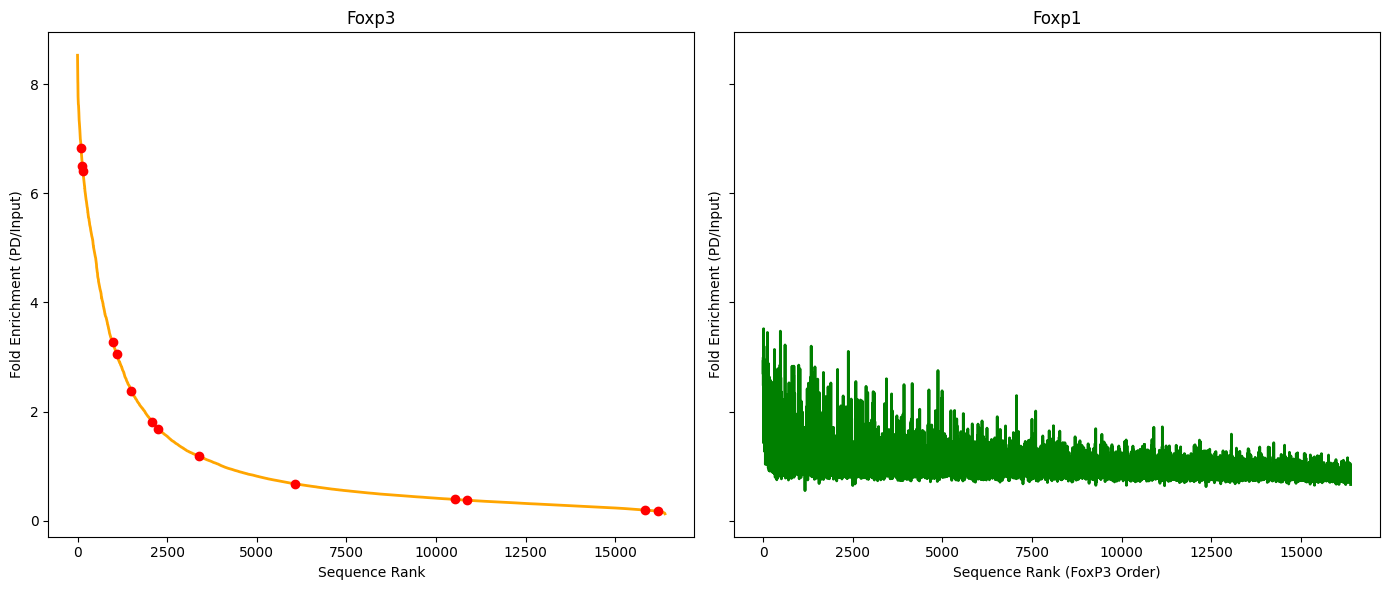

In [7]:
# Plot sorted enrichment (PD/Input) with predefined highlighted sequences of interest
highlight_sequences = [
    "CGCGGCA", "GTAAACA", "CAGGCAC", "GTGGCAC", "AACGCCG",
    "AGGCGAA", "CATGTCA", "CATACTT", "AACATAG", "GAACCAT",
    "AGGGGCG", "TTGGGTC", "GCCTTGA", "CTTCTTC"
]

# Sort
sorted_foxp3_input = summary_df.sort_values(by='Foxp3/Input_RPM', ascending=False).reset_index()
sorted_foxp1_input = summary_df.sort_values(by='Foxp1/Input_RPM', ascending=False).reset_index()

# Shared Y limits
max_ratios_rpm = max(sorted_foxp3_input['Foxp3/Input_RPM'].max(), sorted_foxp1_input['Foxp1/Input_RPM'].max())
min_ratios_rpm = min(sorted_foxp3_input['Foxp3/Input_RPM'].min(), sorted_foxp1_input['Foxp1/Input_RPM'].min())

# Create side-by-side plots
fig, axs = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# Foxp3/Input plot
axs[0].plot(sorted_foxp3_input['Foxp3/Input_RPM'].values, label='Foxp3/Input (RPM)', color='orange', linewidth=2)
for idx, row in sorted_foxp3_input.iterrows():
    if row['sequence'] in highlight_sequences:
        axs[0].scatter(idx, row['Foxp3/Input_RPM'], color='red', zorder=5)
axs[0].set_title('Foxp3')
axs[0].set_xlabel('Sequence Rank')
axs[0].set_ylabel('Fold Enrichment (PD/Input)')

# Foxp1/Input plot
axs[1].plot(sorted_foxp3_input['Foxp1/Input_RPM'].values, label='Foxp1/Input (RPM)', color='green', linewidth=2)
axs[1].set_title('Foxp1')
axs[1].set_xlabel('Sequence Rank (FoxP3 Order)')
axs[1].set_ylabel('Fold Enrichment (PD/Input)')

# Adjust layout and show
plt.tight_layout()
plt.show()

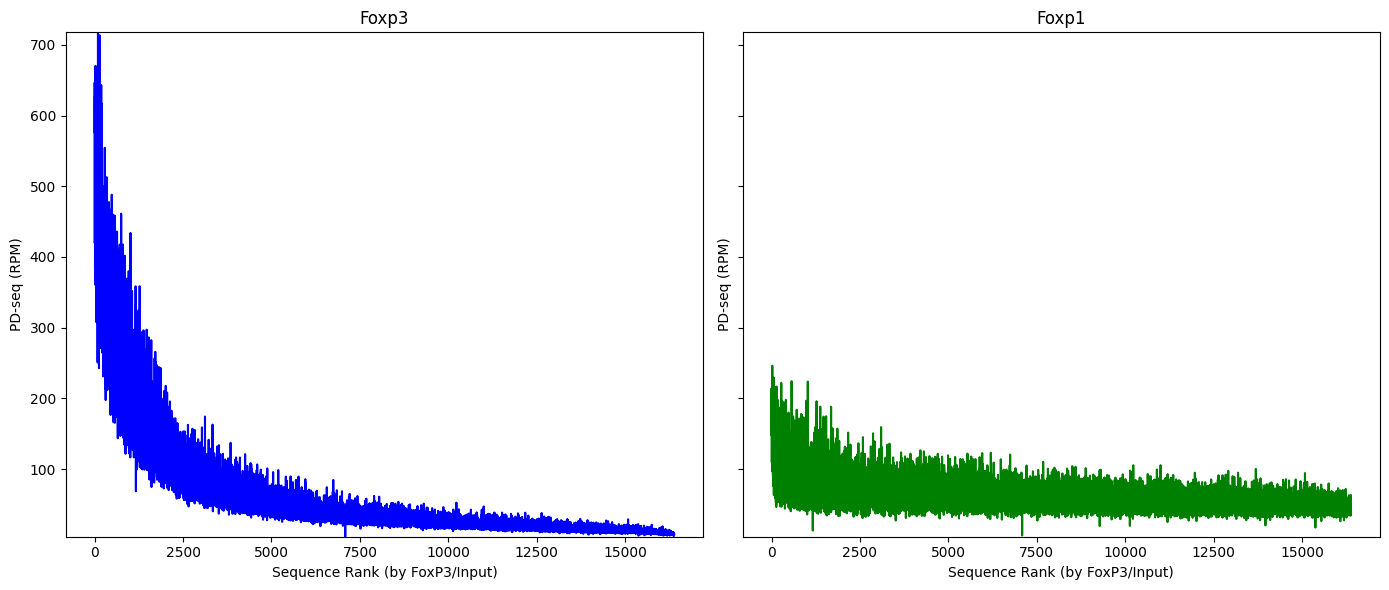

In [8]:
# Plot raw RPM values for Foxp3 and Foxp1 across sequences ranked by Foxp3/Input enrichment
fig, axs = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# Set shared y-axis limits for the top plots
max_counts_rpm = max(summary_df['Foxp3_Counts_RPM'].max(), summary_df['Foxp1_Counts_RPM'].max())
min_counts_rpm = min(summary_df['Foxp3_Counts_RPM'].min(), summary_df['Foxp1_Counts_RPM'].min())

# Set shared y-axis limits for the bottom plots
max_ratios_rpm = max(summary_df['Foxp3/Input_RPM'].max(), summary_df['Foxp1/Input_RPM'].max())
min_ratios_rpm = min(summary_df['Foxp3/Input_RPM'].min(), summary_df['Foxp1/Input_RPM'].min())

# Plot Foxp3 Counts RPM
axs[0].plot(sorted_foxp3_input['Foxp3_Counts_RPM'].values, label='Foxp3 Counts (RPM)', color='blue')
axs[0].set_title('Foxp3')
axs[0].set_xlabel('Sequence Rank (by FoxP3/Input)')
axs[0].set_ylabel('PD-seq (RPM)')
axs[0].set_ylim(min_counts_rpm, max_counts_rpm)

# Plot Foxp1 Counts RPM
axs[1].plot(sorted_foxp3_input['Foxp1_Counts_RPM'].values, label='Foxp1 Counts (RPM)', color='green')
axs[1].set_title('Foxp1')
axs[1].set_xlabel('Sequence Rank (by FoxP3/Input)')
axs[1].set_ylabel('PD-seq (RPM)')
axs[1].set_ylim(min_counts_rpm, max_counts_rpm)

plt.tight_layout()
plt.show()

# Assessment of Replicate Consistency

In [9]:
# Load Replicate 1 and Replicate 2 counts for each sequence in FoxP3
replicate_counts_df = pd.read_csv("figure1_files/rep1_rep2_sequence_counts.csv")

In [10]:
replicate_counts_df.head()

,sequence,Rep1_Count,Rep2_Count
0,AAAAAAA,60,60
1,AAAAAAC,2600,2207
2,AAAAAAG,136,96
3,AAAAAAT,337,315
4,AAAAACA,3599,2958


In [11]:
# Merge enrichment summary with per-replicate sequence counts using the 7-mer as key
summary_df_sorted = summary_df.sort_values(by='Foxp3/Input_RPM', ascending=False)
summary_with_counts = pd.merge(summary_df_sorted, replicate_counts_df, on='sequence', how='left').fillna(0)

# Calculate RPM for Rep1 and Rep2
summary_with_counts['Rep1_Counts_RPM'] = summary_with_counts['Rep1_Count'] / summary_with_counts['Rep1_Count'].sum() * 1e6
summary_with_counts['Rep2_Counts_RPM'] = summary_with_counts['Rep2_Count'] / summary_with_counts['Rep2_Count'].sum() * 1e6

In [12]:
summary_with_counts.head()

,sequence,Foxp1_Counts,Foxp3_Counts,Input_Counts,Foxp3_Counts_RPM,Foxp1_Counts_RPM,Input_Counts_RPM,Foxp3/Input_RPM,Foxp1/Input_RPM,Rep1_Count,Rep2_Count,Rep1_Counts_RPM,Rep2_Counts_RPM
0,TAAACAC,5012,11993,1632,576.534262,197.147753,67.581275,8.530976,2.917195,6502,5488,573.123740,580.598755
1,CAAACAC,5447,13452,1848,646.672133,214.258542,76.525855,8.450374,2.799819,7504,5942,661.445793,628.629337
2,ACAACAC,5129,13167,1814,632.971453,201.749966,75.117912,8.426372,2.685777,7268,5894,640.643394,623.551214
3,TAAACAT,3821,8732,1212,419.769631,150.299594,50.189035,8.363772,2.994670,4740,3994,417.810909,422.542170
4,CACAACA,4433,12229,1701,587.879387,174.372704,70.438571,8.345987,2.475529,6631,5595,584.494544,591.918738


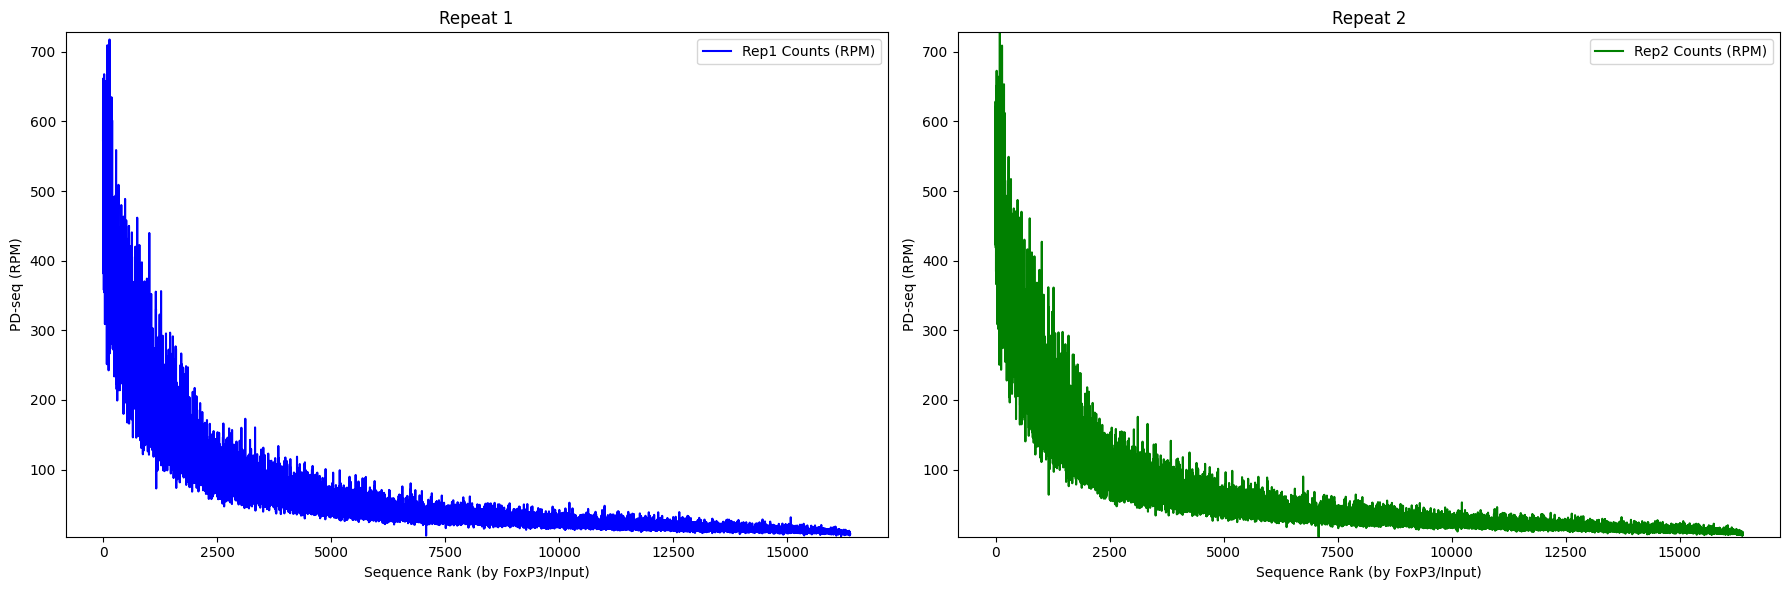

In [13]:
# Plot RPM of Rep1 and Rep2 across ranked sequences
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Determine global y-axis range for consistency
y_min = min(summary_with_counts['Rep1_Counts_RPM'].min(), summary_with_counts['Rep2_Counts_RPM'].min())
y_max = max(summary_with_counts['Rep1_Counts_RPM'].max(), summary_with_counts['Rep2_Counts_RPM'].max())

# Plot Rep1
axs[0].plot(summary_with_counts['Rep1_Counts_RPM'].values, color='blue', label='Rep1 Counts (RPM)')
axs[0].set_title('Repeat 1')
axs[0].set_xlabel('Sequence Rank (by FoxP3/Input)')
axs[0].set_ylabel('PD-seq (RPM)')
axs[0].set_ylim(y_min, y_max)
axs[0].legend()

# Plot Rep2
axs[1].plot(summary_with_counts['Rep2_Counts_RPM'].values, color='green', label='Rep2 Counts (RPM)')
axs[1].set_title('Repeat 2')
axs[1].set_xlabel('Sequence Rank (by FoxP3/Input)')
axs[1].set_ylabel('PD-seq (RPM)')
axs[1].set_ylim(y_min, y_max)
axs[1].legend()

plt.tight_layout()
plt.show()

# Fixed Motif Detection and Enrichment Calculation for FKHM + Ran

### Identifying top 10 2N motifs

In [14]:
# Create a dictionary of (Foxp3_RPM, Input_RPM) by 7-mer
rpm_dict = dict(zip(summary_df['sequence'], zip(summary_df['Foxp3_Counts_RPM'], summary_df['Input_Counts_RPM'])))

# Generate all 2N masking combinations
mask_combos = list(itertools.combinations(range(7), 2))

def apply_mask(seq, positions):
    """Mask specified positions in sequence with 'N'."""
    seq_list = list(seq)
    for pos in positions:
        seq_list[pos] = 'N'
    return ''.join(seq_list)

# Group sequences by their masked version
masked_groups = defaultdict(list)
for seq in summary_df['sequence']:
    for mask in mask_combos:
        masked = apply_mask(seq, mask)
        masked_groups[(masked, mask)].append(seq)

# Compute combined enrichment for each masked motif by summing RPM across contributing sequences
results = []
for (masked_seq, mask), group in masked_groups.items():
    if len(group) < 2:
        continue  # Skip singletons

    foxp3_sum = sum(rpm_dict[seq][0] for seq in group)
    input_sum = sum(rpm_dict[seq][1] for seq in group)
    if input_sum == 0:
        continue  # Avoid division by zero

    enrichment = foxp3_sum / input_sum
    results.append({
        '2N_motif': masked_seq,
        'N_positions': mask,
        'contributing_sequences': group,
        'foxp3_rpm': foxp3_sum,
        'input_rpm': input_sum,
        'enrichment': enrichment
    })

# Create dataframe and select top 10 enriched motifs
motif_df = pd.DataFrame(results)
motifs = motif_df.sort_values(by='enrichment', ascending=False)
top10_motifs = motifs.head(10).copy()

In [15]:
top10_motifs

,2N_motif,N_positions,contributing_sequences,foxp3_rpm,input_rpm,enrichment
15659,GATGCNN,"(5, 6)","[GATGCAA, GATGCAC, GATGCAG, GATGCAT, GATGCCA, ...",6864.714094,983.448344,6.980249
1677,NNCAACA,"(0, 1)","[AACAACA, ACCAACA, AGCAACA, ATCAACA, CACAACA, ...",7638.249724,1116.126288,6.843535
9457,ATGCANN,"(5, 6)","[ATGCAAA, ATGCAAC, ATGCAAG, ATGCAAT, ATGCACA, ...",7569.409812,1117.906922,6.771056
66,NNAAACA,"(0, 1)","[AAAAACA, ACAAACA, AGAAACA, ATAAACA, CAAAACA, ...",5813.607478,863.938810,6.729189
205,NAAACAN,"(0, 6)","[AAAACAA, AAAACAC, AAAACAG, AAAACAT, CAAACAA, ...",5843.220177,877.686961,6.657522
3958,AATGCNN,"(5, 6)","[AATGCAA, AATGCAC, AATGCAG, AATGCAT, AATGCCA, ...",6419.850585,982.951423,6.531198
9496,ATGCGNN,"(5, 6)","[ATGCGAA, ATGCGAC, ATGCGAG, ATGCGAT, ATGCGCA, ...",7433.508673,1153.975114,6.441654
4356,NCAACAN,"(0, 6)","[ACAACAA, ACAACAC, ACAACAG, ACAACAT, CCAACAA, ...",6829.188469,1062.665855,6.426468
3955,NATGCAN,"(0, 6)","[AATGCAA, AATGCAC, AATGCAG, AATGCAT, CATGCAA, ...",6721.986651,1074.384912,6.256591
9460,ATGCNNC,"(4, 5)","[ATGCAAC, ATGCACC, ATGCAGC, ATGCATC, ATGCCAC, ...",8062.201668,1313.818081,6.136467


### Plots related to PD-seq motif counts and enrichment 

/tmp/ipykernel_23932/2233468627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reverse_df['2N_motif'] = pd.Categorical(reverse_df['2N_motif'], categories=reverse_compliment_seqs, ordered=True)


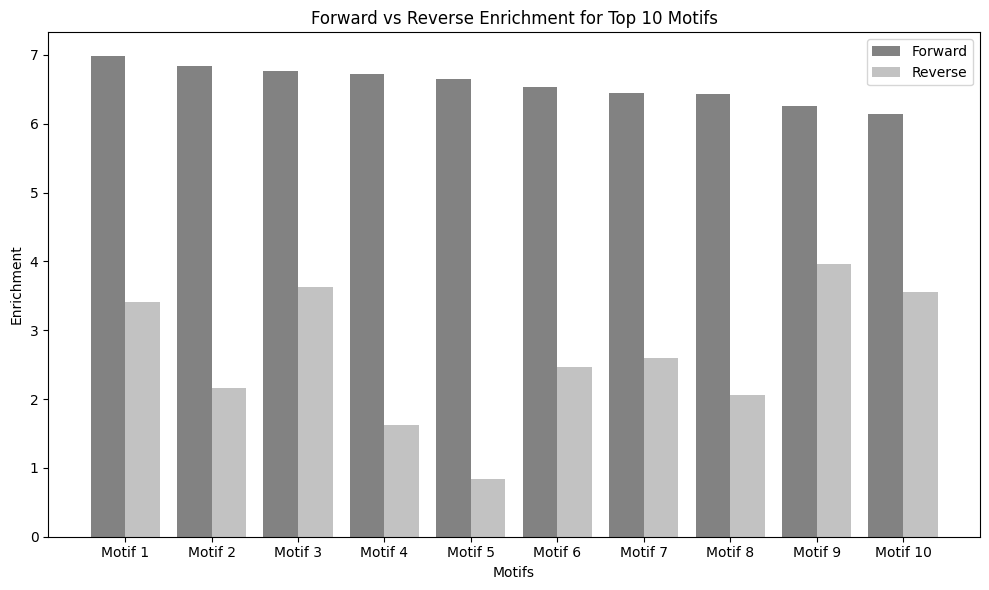

In [16]:
# Predefined reverse-complement 2N motifs of the top 10 enriched forward motifs
reverse_compliment_seqs = ['NNGCATC', 'TGTTGNN', 'NNTGCAT', 'TGTTTNN', 'NTGTTTN', 
                 'NNGCATT', 'NNCGCAT', 'NTGTTGN', 'NTGCATN', 'GNNGCAT']

# Get enrichment values
forward_enrich = top10_motifs['enrichment'].values
reverse_df = motifs[motifs['2N_motif'].isin(reverse_compliment_seqs)]
reverse_df['2N_motif'] = pd.Categorical(reverse_df['2N_motif'], categories=reverse_compliment_seqs, ordered=True)
reverse_df = reverse_df.sort_values('2N_motif').reset_index(drop=True)
reverse_enrich = reverse_df['enrichment'].values

# Bar plot settings
motif_labels = [f"Motif {i+1}" for i in range(10)]
bar_width = 0.4
x = np.arange(len(motif_labels))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, forward_enrich, bar_width, label='Forward', alpha=0.7, color='#4D4D4D')
plt.bar(x + bar_width/2, reverse_enrich, bar_width, label='Reverse', alpha=0.7, color='#A9A9A9')

plt.xticks(x, motif_labels)
plt.xlabel('Motifs')
plt.ylabel('Enrichment')
plt.title('Forward vs Reverse Enrichment for Top 10 Motifs')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Highlight sequences contributing to the top 10 enriched motifs (by group: 1N, 2N, 3N)
masked_seq_df = pd.read_csv('figure1_files/top10_masked_motif_contributors.csv')

In [18]:
# Get one example from each N_Gap group
examples = []
for n_gap in ['1N', '2N', '3N']:
    example_row = (
        masked_seq_df[masked_seq_df['N_Gap'] == n_gap]
        .groupby('Enriched_Seq')['Contributing_Seq']
        .apply(list)
        .reset_index()
        .iloc[0]  # take the first example
    )
    examples.append((n_gap, example_row['Enriched_Seq'], example_row['Contributing_Seq']))

# Print clean summary
for n_gap, enriched_seq, contributing_list in examples:
    print(f"• {n_gap} — Enriched Motif: {enriched_seq}")
    print(f"  Contributing Sequences: {', '.join(contributing_list)}\n")

• 1N — Enriched Motif: ACAACAN
  Contributing Sequences: ACAACAA, ACAACAC, ACAACAG, ACAACAT

• 2N — Enriched Motif: AATGCNN
  Contributing Sequences: AATGCAA, AATGCAC, AATGCAG, AATGCAT, AATGCCA, AATGCCC, AATGCCG, AATGCCT, AATGCGA, AATGCGC, AATGCGG, AATGCGT, AATGCTA, AATGCTC, AATGCTG, AATGCTT

• 3N — Enriched Motif: ATGCNNN
  Contributing Sequences: ATGCAAA, ATGCAAC, ATGCAAG, ATGCAAT, ATGCACA, ATGCACC, ATGCACG, ATGCACT, ATGCAGA, ATGCAGC, ATGCAGG, ATGCAGT, ATGCATA, ATGCATC, ATGCATG, ATGCATT, ATGCCAA, ATGCCAC, ATGCCAG, ATGCCAT, ATGCCCA, ATGCCCC, ATGCCCG, ATGCCCT, ATGCCGA, ATGCCGC, ATGCCGG, ATGCCGT, ATGCCTA, ATGCCTC, ATGCCTG, ATGCCTT, ATGCGAA, ATGCGAC, ATGCGAG, ATGCGAT, ATGCGCA, ATGCGCC, ATGCGCG, ATGCGCT, ATGCGGA, ATGCGGC, ATGCGGG, ATGCGGT, ATGCGTA, ATGCGTC, ATGCGTG, ATGCGTT, ATGCTAA, ATGCTAC, ATGCTAG, ATGCTAT, ATGCTCA, ATGCTCC, ATGCTCG, ATGCTCT, ATGCTGA, ATGCTGC, ATGCTGG, ATGCTGT, ATGCTTA, ATGCTTC, ATGCTTG, ATGCTTT



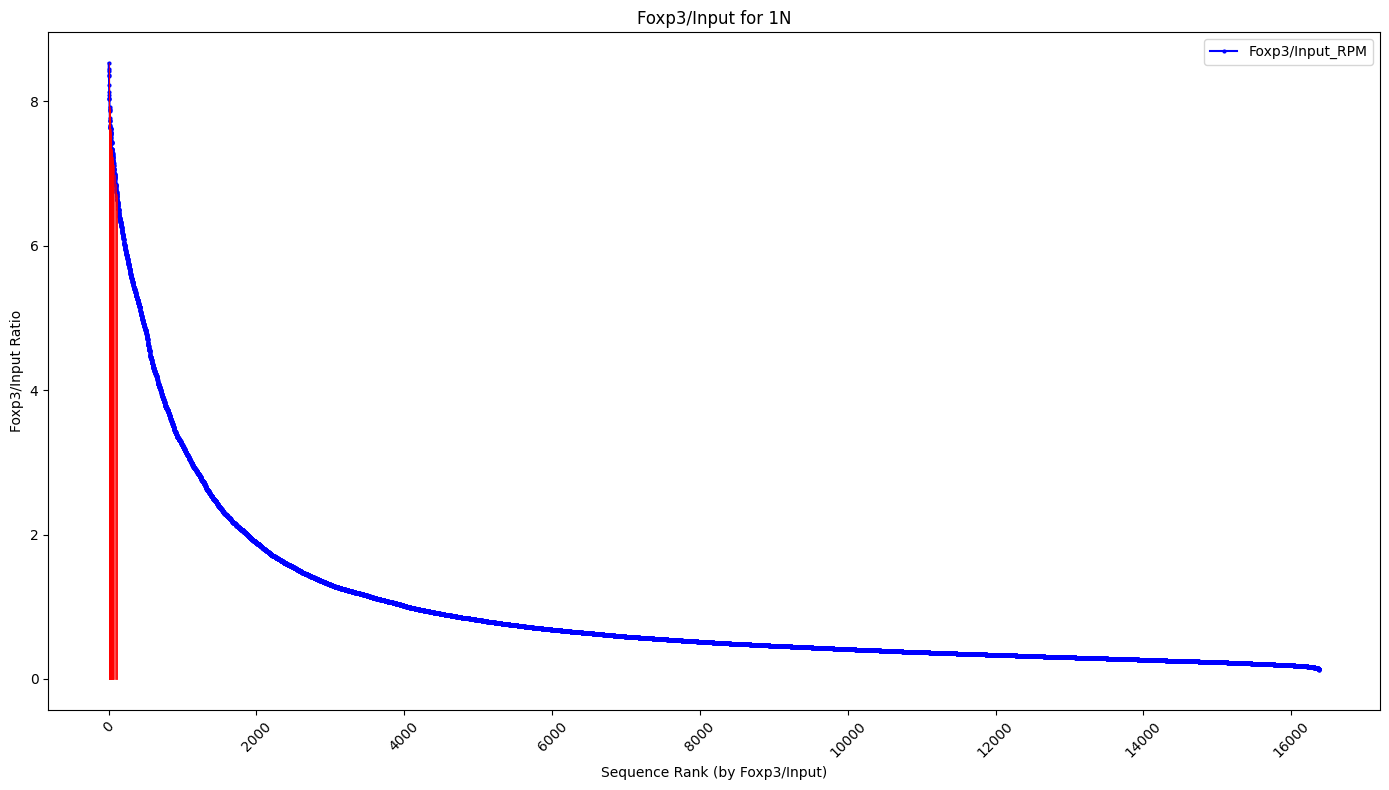

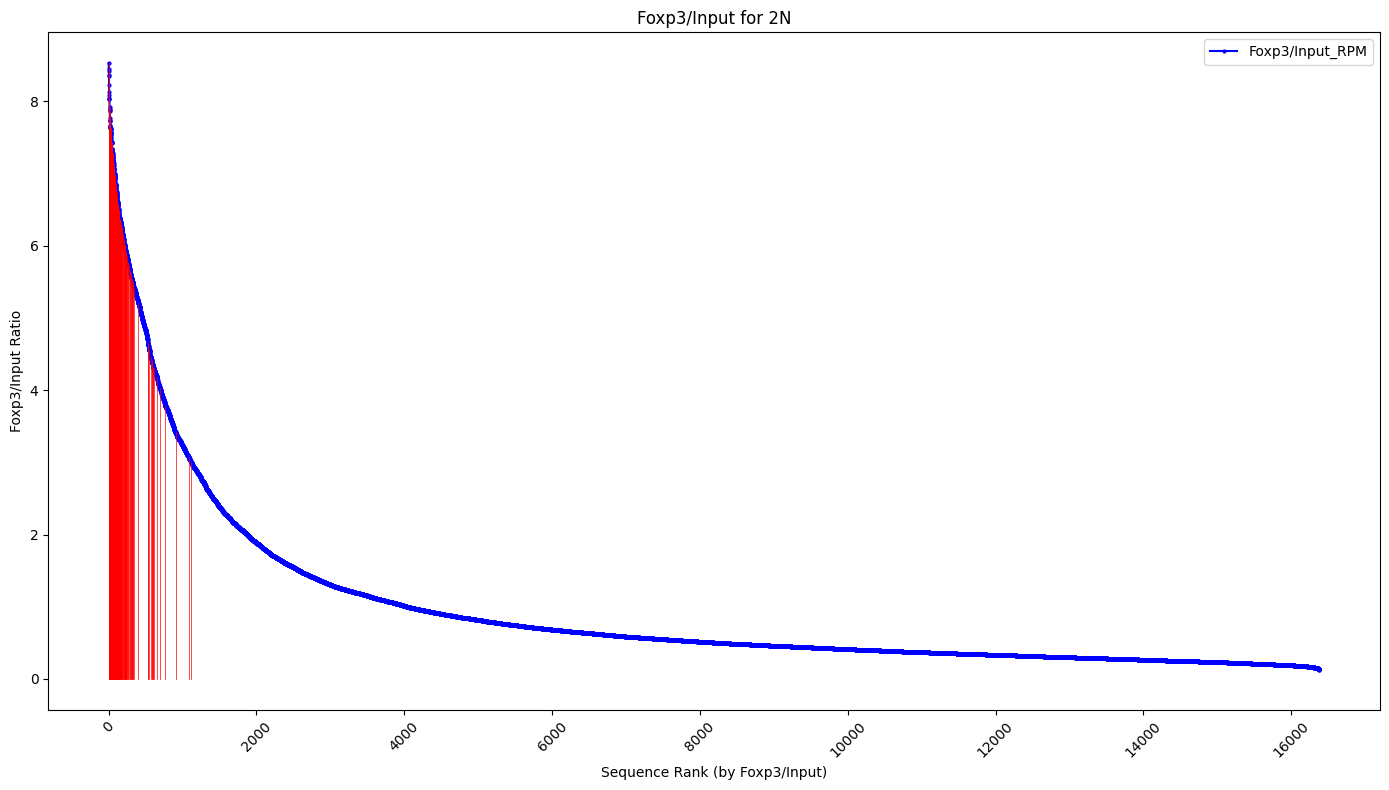

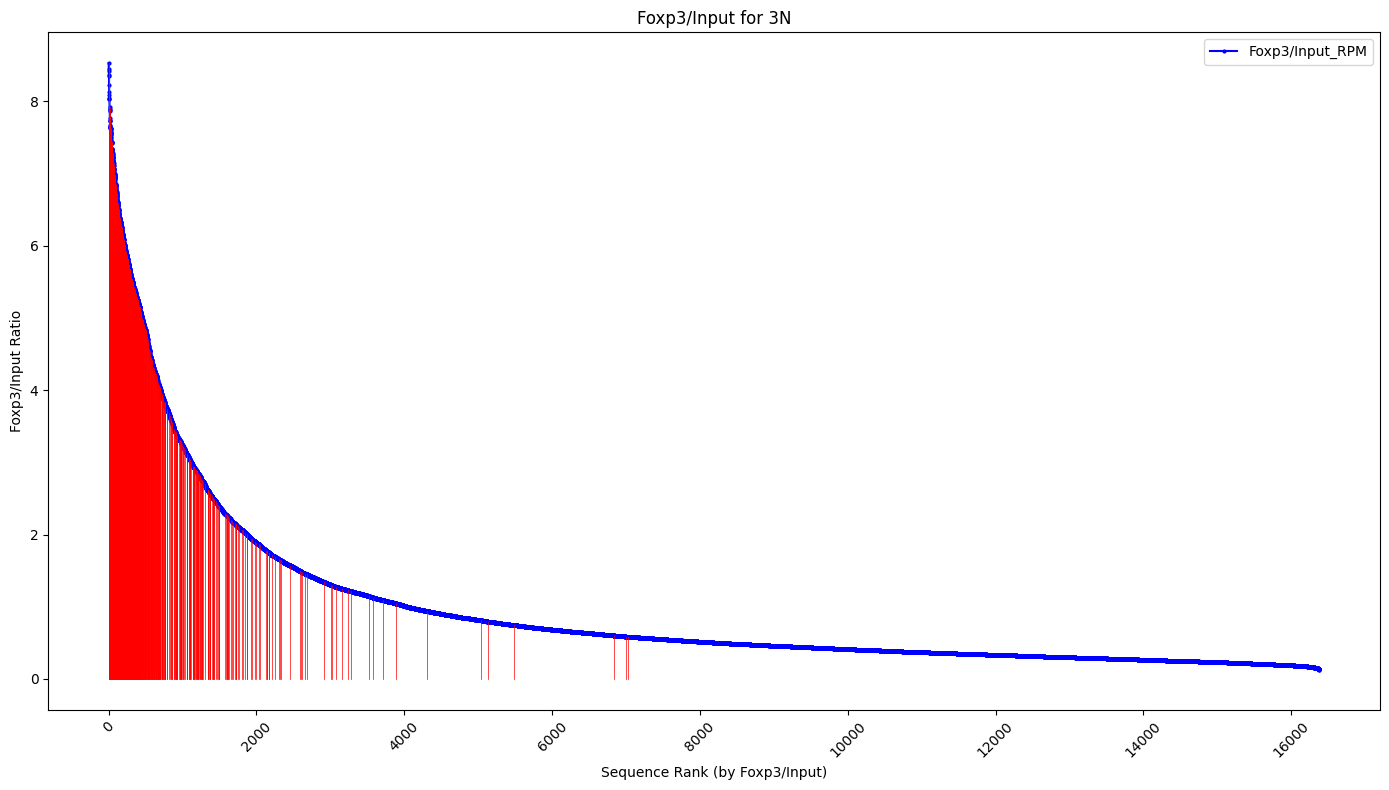

In [19]:
# Sort once for consistent x-axis
sorted_df = summary_df.sort_values(by='Foxp3/Input_RPM', ascending=False).reset_index(drop=True)
x_labels = sorted_df['sequence'].tolist()
y_values = sorted_df['Foxp3/Input_RPM'].tolist()

# Plot for each N
for n_gap in ['1N', '2N', '3N']:
    subset = masked_seq_df[masked_seq_df['N_Gap'] == n_gap]
    highlight_seqs = set(subset['Contributing_Seq'])

    highlight_rows = sorted_df[sorted_df['sequence'].isin(highlight_seqs)]

    plt.figure(figsize=(14, 8))
    x_indices = range(len(x_labels))
    plt.plot(x_indices, y_values, marker='o', linestyle='-', color='blue', label='Foxp3/Input_RPM', markersize=2)

    for _, row in highlight_rows.iterrows():
        idx = x_labels.index(row['sequence'])
        plt.plot([idx, idx], [0, row['Foxp3/Input_RPM']], color='red', linestyle='-', linewidth=0.5)

    plt.title(f'Foxp3/Input for {n_gap}')
    plt.xlabel('Sequence Rank (by Foxp3/Input)')
    plt.ylabel('Foxp3/Input Ratio')
    plt.xticks(ticks=range(0, len(x_labels), 2000), labels=range(0, len(x_labels), 2000), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()